### In this lab we will be using the Hugging Face Transformers library to generate summaries of dialogues.

- We can use the Hugging Face Transformers library to generate summaries of dialogues.
- The model recieves a prompt and generates a summary of the dialogue.
- We use few shot inference to improve the model's performance. 
- This few shot prompt comes from the test dataset. In other words, we are using some examples of dialogue to the One / Few-Shot Technique

In [1]:
# Env: transformers_env (Python 3.9.21)

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import GenerationConfig

In [3]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [4]:
example_indices = [40, 200]
dash_line = '-'.join('' for i in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOG:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()


---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOG:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Examp

* The Idea is to use a LLM to improve the summary of the input dialogue. 

In [5]:
model_name = 'google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

### Tokenizer to the Encoder step on Transformer Architecture

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [7]:
sentence = "What is the capital of France?" # The input phrase

sentence_encoded = tokenizer(sentence, return_tensors='pt') # The Tokenizer

sentence_decoded = tokenizer.decode(
    sentence_encoded['input_ids'][0], 
    skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded['input_ids'][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

ENCODED SENTENCE:
tensor([ 363,   19,    8, 1784,   13, 1410,   58,    1])

DECODED SENTENCE:
What is the capital of France?


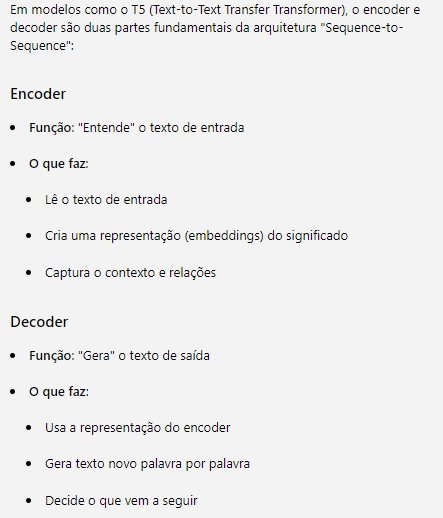

#### Now we can use the model to generate a summary of the input dialogue.


In [28]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue'] # Text format
    summary = dataset['test'][index]['summary'] # Text format

    inputs = tokenizer(dialogue, return_tensors='pt') # Tokenize the dialogue 
    
    outputs = model.generate( 
        inputs['input_ids'], # Input as a tokenized tensor
        max_new_tokens=100,
    )[0]
    
    decoded_output = tokenizer.decode(outputs, skip_special_tokens=True) # Decode the output to text

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT DIALOGUE: {dialogue}')
    print(f'BASELINE HUMAN SUMMARY: {summary}')
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING: {decoded_output}')
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE: #Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
BASELINE HUMAN SUMMARY: #Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
MODEL GENERATION - WITHOUT PROMPT ENGINEERING: Person1: It's ten to nine.
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Example  2
------------------

### 3. Summarize Dialogues with an Instruction Prompt




#### 3.1 Zero Shot Inference with an Instruction Prompt

In [29]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
    
    # Prompt setp
    prompt = f"""
Summarize the following conversation.

Conversation:
{dialogue}

Summary:
    """
    
    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt') # Tokenize the prompt 
    
    outputs = model.generate(
        inputs['input_ids'], # The input prompt is a text tokenized
        max_new_tokens=100,
    )[0]
    
    decoded_output = tokenizer.decode(outputs, skip_special_tokens=True) # Decode the output to text
    
    '''
    # This is the same as the previous code but without the prompt engineering.
    outputs = tokenizer.decode(model.generate(
        inputs['input_ids'],
        max_new_tokens=50,
    )[0], skip_special_tokens=True)
    '''

print(dash_line)
print('Example ', i + 1)
print(dash_line)
print(f'INPUT PROMPT: {prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY: {summary}')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT: {decoded_output}')
print(dash_line)
print()


---------------------------------------------------------------------------------------------------
Example  2
---------------------------------------------------------------------------------------------------
INPUT PROMPT: 
Summarize the following conversation.

Conversation:
#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out

#### 3.2 Zero Shot Inference with an Instruction Prompt 2

We are trying to get the model to summarize the dialogue.
So, our goal is to find the best prompt to get the model to do this task.


In [33]:
# Zero Shot Inferecen with an Instruction Prompt:

for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue'] # This is an dictionary
    summary = dataset['test'][index]['summary'] # 

    prompt = f"""
Dialogue:
{dialogue}

What is going on here?
Summary:
    """
    
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs_decoded = tokenizer.decode(model.generate(
        inputs['input_ids'],
        max_new_tokens=100,
    )[0], skip_special_tokens=True)
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT: {prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY: {summary}')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT: {outputs_decoded}')
    print(dash_line)
    print()


---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT: 
Dialogue:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What is going on here?
Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY: #Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT: Tom is late for the train.


## 4. Summarize Dialogue with One Shot and Few Shot Inference


- One Shot Inference is when we provide the model with one example of the task.
- Few Shot Inference is when we provide the model with multiple examples of the task.

This is called "in-context learning" and puts your model in a better position to do the task.


### 4.1 - One Shot Inference


Let's build a function that takes a list of example_indices_full, generates a prompt with full examples, then at the end appends the prompt which you want the model to complete (example_index_to_summarize). You will use the same FLAN-T5-Base template from section 3.2.


In [34]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = "" # Define a prompt variable as a string (text)
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
        prompt += f"""
Dialogue:
{dialogue}

What is going on here?
Summary:
{summary}
"""
    dialogue = dataset['test'][example_index_to_summarize]['dialogue']
    
    prompt += f"""
Dialogue:
{dialogue}

What is going on here?
"""
    return prompt

In [35]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)
print(one_shot_prompt)


Dialogue:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What is going on here?
Summary:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

Dialogue:
#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And yo

### 4.2 - Few Shot Inference

Let's explore few shot inference by adding two more full dialogue-summary pairs to the prompt.





In [36]:
example_indices_full = [40, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)
print(few_shot_prompt)


Dialogue:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What is going on here?
Summary:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

Dialogue:
#Person1#: May, do you mind helping me prepare for the picnic?
#Person2#: Sure. Have you checked the weather report?
#Person1#: Yes. It says it will be sunny all day. No sign of rain at all. This is your father's favorite sausage. Sandwiches for you and Daniel.
#Person2#: No, thanks Mom. I'd like some toast and chicken wings.
#Person1#: Okay. Please take some fruit salad and crackers for me.
#Person2#: Done. Oh, don't forget to take napkins disposable plates, cups and picnic blanket.
#Person1#: 

Now pass this prompt to the model and see how it performs:


In [37]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')

outputs_decoded = tokenizer.decode(
    model.generate(inputs['input_ids'], 
                   max_new_tokens=50)[0], 
    skip_special_tokens=True
    )

print(dash_line)
print(f'INPUT PROMPT: {few_shot_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY: {summary}')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT: {outputs_decoded}')
print(dash_line)
print()


---------------------------------------------------------------------------------------------------
INPUT PROMPT: 
Dialogue:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What is going on here?
Summary:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

Dialogue:
#Person1#: May, do you mind helping me prepare for the picnic?
#Person2#: Sure. Have you checked the weather report?
#Person1#: Yes. It says it will be sunny all day. No sign of rain at all. This is your father's favorite sausage. Sandwiches for you and Daniel.
#Person2#: No, thanks Mom. I'd like some toast and chicken wings.
#Person1#: Okay. Please take some fruit salad and crackers

### 5 - Generative Configuration Parameters for Inference


In [42]:
# generation_config is a configuration object for the model's generation process.
# It allows you to specify various parameters for the generation process, such as the maximum number of tokens to generate, the temperature, and the top-k and top-p sampling parameters.

# max_new_tokens is the maximum number of tokens to generate.
# do_sample is a boolean that determines whether to use sampling or not.
# temperature is a float that determines the randomness of the generation process.

max_new_tokens = 50 # The maximum numbers of tokens to generate, ignoring the number of tokens in the prompt.
do_sample = True # 
temperature = 0.2 # 
generation_config = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=do_sample, temperature=temperature)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')

outputs_decoded = tokenizer.decode(
    model.generate(
        inputs['input_ids'],
        generation_config=generation_config,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT: {outputs_decoded}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY: {summary}')
print(dash_line)
print()

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT: Summary: #Person1 wants to upgrade his computer. He needs a painting program and a hard disc. He needs a CD-ROM drive.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------



In [43]:
# generation_config is a configuration object for the model's generation process.
# It allows you to specify various parameters for the generation process, such as the maximum number of tokens to generate, the temperature, and the top-k and top-p sampling parameters.

# max_new_tokens is the maximum number of tokens to generate.
# do_sample is a boolean that determines whether to use sampling or not.
# temperature is a float that determines the randomness of the generation process.

max_new_tokens = 50 
do_sample = True
temperature = 0.4
generation_config = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=do_sample, temperature=temperature)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
outputs_decoded = tokenizer.decode(
    model.generate(
        inputs['input_ids'],
        generation_config=generation_config,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT: {outputs_decoded}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY: {summary}')
print(dash_line)
print()

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT: Summary: #Person1# wants to upgrade his system. #Person2#: Yes, but he's not sure what exactly he wants. #Person1#: You could add a painting program to your software
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------



In [44]:
# generation_config is a configuration object for the model's generation process.
# It allows you to specify various parameters for the generation process, such as the maximum number of tokens to generate, the temperature, and the top-k and top-p sampling parameters.

# max_new_tokens is the maximum number of tokens to generate.
# do_sample is a boolean that determines whether to use sampling or not.
# temperature is a float that determines the randomness of the generation process.

max_new_tokens = 50 
do_sample = True
temperature = 0.5
generation_config = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=do_sample, temperature=temperature)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
outputs_decoded = tokenizer.decode(
    model.generate(
        inputs['input_ids'],
        generation_config=generation_config,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT: {outputs_decoded}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY: {summary}')
print(dash_line)
print()

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT: Summary: #Person1 is looking into upgrading his system. He wants to add a painting program. He wants to add a CD-ROM drive.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------



Vou explicar as principais diferenças entre os modelos disponíveis na biblioteca Transformers e os modelos do Google (como PaLM) e OpenAI (como GPT-4):
Modelos Hugging Face (Transformers)

Vantagens:
- ✅ Código aberto (open source)
- ✅ Gratuitos para uso e modificação
- ✅ Podem ser executados localmente
- ✅ Personalizáveis (fine-tuning)
- ✅ Controle total sobre o deployment
- ✅ Sem dependência de API externa

Limitações: 
- ❌ Geralmente menor capacidade/performance
- ❌ Modelos menores (normalmente < 20B parâmetros)
- ❌ Requerem mais conhecimento técnico
- ❌ Necessitam infraestrutura própria

Modelos Google/OpenAI

Vantagens:
- ✅ Performance superior
- ✅ Modelos muito maiores (> 100B parâmetros)
- ✅ Atualizados constantemente
- ✅ Fáceis de usar via API
- ✅ Não requerem infraestrutura própria

Limitações:
- ❌ Código fechado
- ❌ Pagos (baseado em uso)
- ❌ Dependência de conexão internet
- ❌ Sem controle sobre o modelo
- ❌ Possíveis problemas de privacidade

Comparação de Uso

Quando Usar Cada Um?

Use Transformers quando:
- Precisar de controle total sobre o modelo
- Tiver restrições de privacidade/dados
- Necessitar processamento offline
- Orçamento limitado
- Projeto acadêmico ou pesquisa

Use Google/OpenAI quando:
- Precisar da melhor performance possível
- Não tiver restrições de privacidade
- Tiver orçamento disponível
- Precisar de respostas mais sofisticadas
- Desenvolvimento rápido de aplicações

Exemplo de Diferença de Performance
Em resumo, a escolha entre usar modelos da biblioteca Transformers ou serviços como OpenAI/Google depende muito do seu caso de uso específico, considerando fatores como orçamento, requisitos de privacidade, necessidade de performance e infraestrutura disponível.


